<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Πτυχιακή Εργασία

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define dataset path (adjust if needed)
dataset = 'drive/MyDrive/DFU_Data'
original = dataset + '/images'
trainset = dataset + '/train'
testset = dataset + '/test'
validset = dataset + '/valid'

# List categories (folders)
# os.listdir(original)

In [3]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

## Data Exploration

### Average Images

In [ ]:
def compute_average_image(image_dir, img_size=(224, 224)):
    all_images = []
    for file_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(img_size)
                all_images.append(np.array(img, dtype=np.float32))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if all_images:
        mean_image = np.mean(all_images, axis=0).astype(np.uint8)
        return mean_image
    else:
        print(f"No images found in {image_dir}.")
        return None


In [ ]:
# Compute average image for image patches
average_image = compute_average_image(original)

#### Visualizing Averages of the Dataset and the Train Set

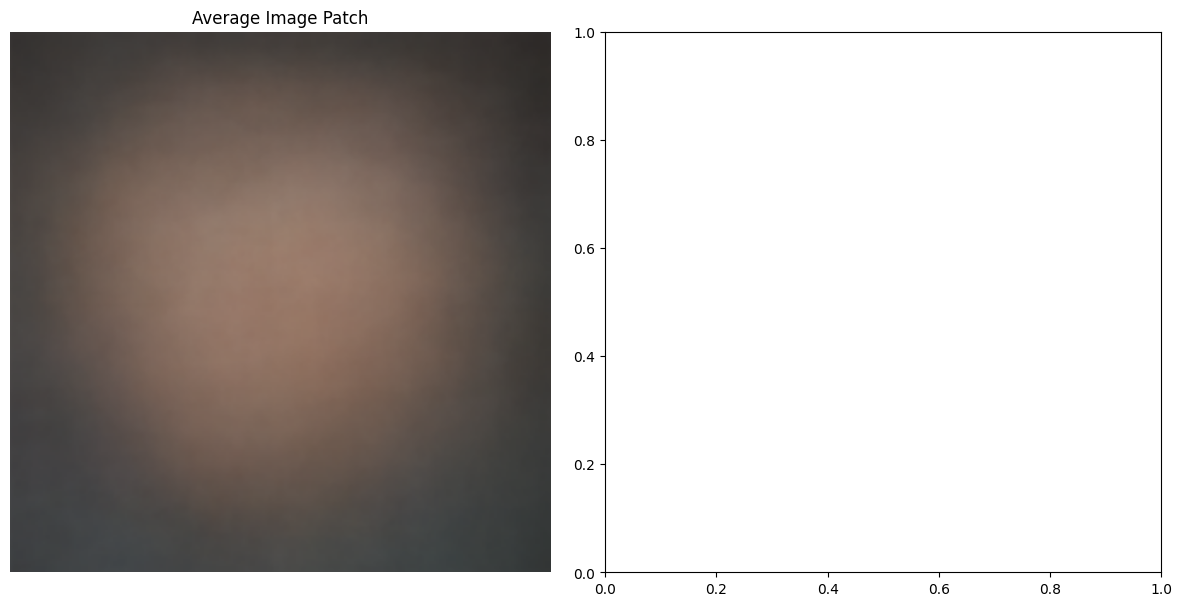

In [ ]:
# Plotting the average images
fig, axes = plt.subplots(1,2, figsize=(12, 6))

if average_image is not None:
    axes[0].imshow(average_image)
    axes[0].set_title("Average Image Patch")
    axes[0].axis("off")
else:
    axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center')
    axes[0].set_title("Average Image Patch")
    axes[0].axis("off")

plt.tight_layout()
plt.show()



### Comparing sizes of the images in the dataset

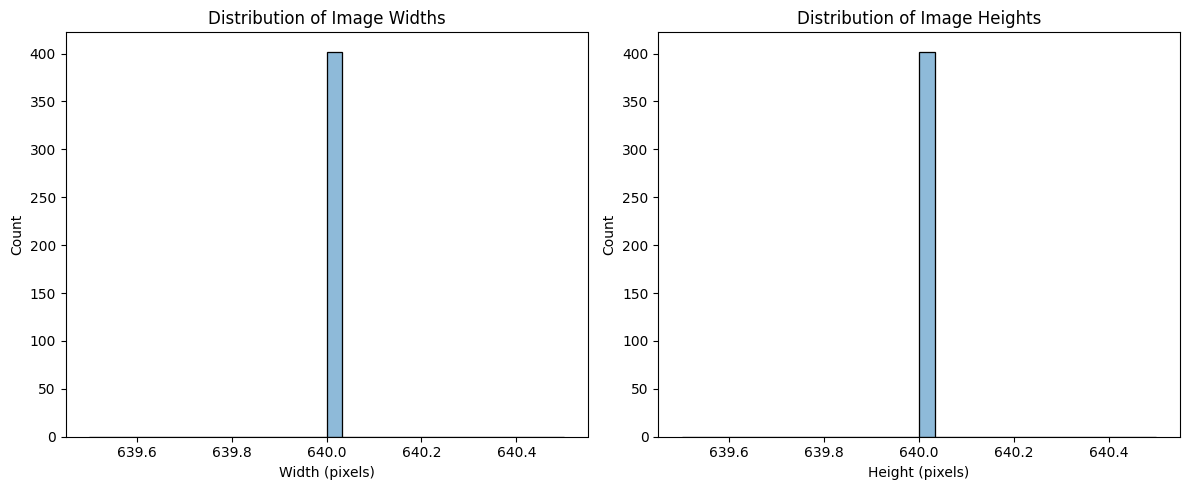

In [ ]:
widths = []
heights = []

for filename in os.listdir(original):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        with Image.open(os.path.join(original, filename)) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()


## Data Preprocessing

### Reading Dataset using Tensoflow

In [4]:
# Load dataset
batch_size = 32
img_size = (640, 640)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainset,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validset,
    validation_split = 0.2,
    subset = "validation",
    shuffle=True,
    seed = 123,
    batch_size=batch_size,
    image_size=img_size
)

# Get class names
class_names = train_dataset.class_names

Found 285 files belonging to 2 classes.
Using 228 files for training.
Found 77 files belonging to 2 classes.
Using 15 files for validation.


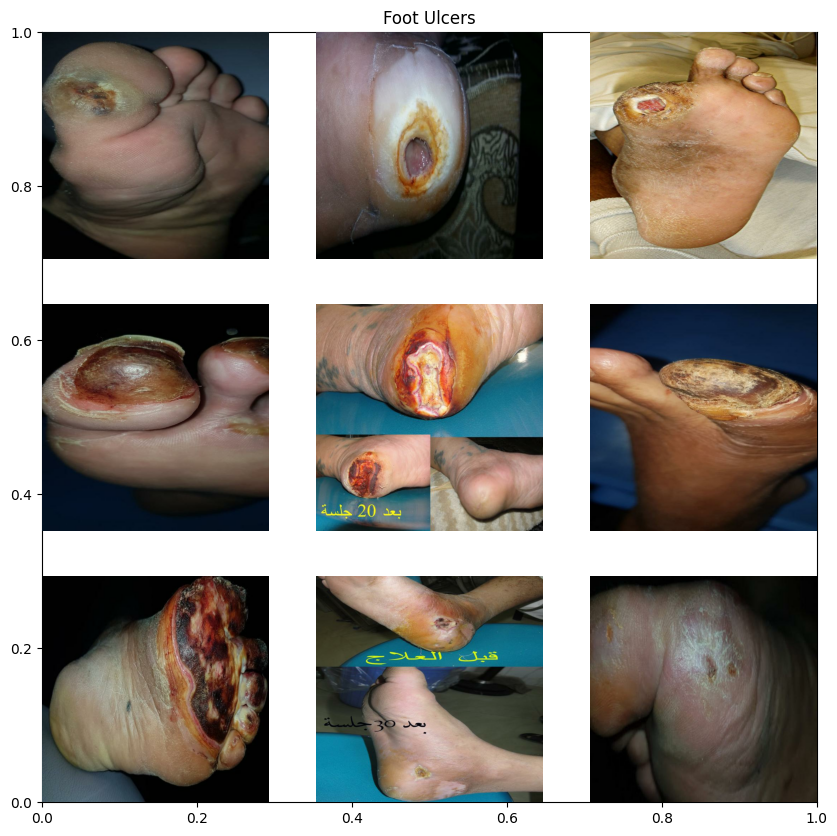

In [5]:
# Get a batch of images
plt.figure(figsize=(10, 10))
plt.title('Foot Ulcers')
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Normalize Images Layer(Divide Pixel values with 255)

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Data Augmentation Layer

In [7]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    # Add other augmentation layers as needed
])

### Apply the preprocessing steps to the train and validation set

In [8]:
def preprocess(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

## Model Training

### YOLOv11

In [10]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.90 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 40.7/235.7 GB disk)


#### Hyperparameter Optimization

In [15]:
from ultralytics import YOLO

search_space = {
    'lr0': (1e-4, 1e-2),       # Learning rate
    'momentum': (0.85, 0.95),  # Momentum
    'weight_decay': (1e-5, 1e-3),  # Weight decay
    'scale': (0.5, 1.5),       # Scale augmentation
    'translate': (0.0, 0.2)    # Translation augmentation
}


# Load your YOLOv8 model
model = YOLO('yolo11n.pt')

# Dataset yaml
my_yaml = '/content/drive/MyDrive/DFU_Data/mydata.yaml'

# Execute hyperparameter tuning
results = model.tune(
    data=my_yaml,
    space=search_space,
    epochs=100,             # Number of epochs per trial
    optimizer='Adam',      # Optimizer choice
    plots=True             # Enable plotting of results
)


Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune5'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'scale': 0.5, 'translate': 0.1}
Saved runs/detect/tune5/tune_scatter_plots.png
Saved runs/detect/tune5/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (316.95s)
Tuner: Results saved to runs/detect/tune5
Tuner: Best fitness=0.33298 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.74753, 'metrics/recall(B)': 0.47293, 'metrics/mAP50(B)': 0.60613, 'metrics/mAP50-95(B)': 0.30263, 'val/box_loss': 1.82821, 'val/cls_loss': 1.55149, 'val/dfl_loss': 1.82394, 'fitness': 0.33298}
Tuner: Best fitness model is runs/detect/train16
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs/detect/tune5/best_hyperparameters.yaml'

lr0: 0.01
momentum: 0.937
weight_decay: 0.0005
scale: 0.5
tra

In [ ]:
d